In [1]:
import struct
import os
import numpy as np
from matplotlib import pyplot as plt
class MNIST(object):
    '''
    MNIST数据集类
    '''
    def __init__(self,root, image_file, lable_file):
        '''
        方法说明:
            初始化类
        参数说明:
            root: 文件夹根目录
            image_file: mnist图像文件 'train-images.idx3-ubyte' 'test-images.idx3-ubyte'
            label_file: mnist标签文件 'train-labels.idx1-ubyte' 'test-labels.idx1-ubyte'
        '''
        self.img_file = os.path.join(root, image_file)
        self.label_file = os.path.join(root, lable_file)
        
        self.img = self._get_img()
        self.label = self._get_label()

    #读取图片
    def _get_img(self):

        with open(self.img_file,'rb') as fi:
            ImgFile = fi.read()
            head = struct.unpack_from('>IIII', ImgFile, 0)
            #定位数据开始位置
            offset = struct.calcsize('>IIII')
            ImgNum = head[1]
            width = head[2]
            height = head[3]
            #每张图片包含的像素点
            pixel = height*width
            bits = ImgNum * width * height
            bitsString = '>' + str(bits) + 'B'
            #读取文件信息
            images = struct.unpack_from(bitsString, ImgFile, offset)
            #转化为n*726矩阵
            images = np.reshape(images,[ImgNum,pixel])
        
        return images

    #读取标签
    def _get_label(self):

        with open(self.label_file,'rb') as fl:
            LableFile = fl.read()
            head = struct.unpack_from('>II', LableFile, 0)
            labelNum = head[1]
            #定位标签开始位置
            offset = struct.calcsize('>II')
            numString = '>' + str(labelNum) + "B"
            labels = struct.unpack_from(numString, LableFile, offset)
            #转化为1*n矩阵
            labels = np.reshape(labels, [labelNum])

        return labels

    #数据标准化
    def normalize(self):
        
        min = np.min(self.img, axis=1).reshape(-1,1)
        max = np.max(self.img, axis=1).reshape(-1,1)
        self.img = (self.img - min)/(max - min)

    #数据归一化
    def standardlize(self):
        
        mean = np.mean(self.img, axis=1).reshape(-1,1)
        var = np.var(self.img, axis=1).reshape(-1,1)
        self.img = (self.img-mean)/np.sqrt(var)
        
    def out(self):
        self.standardlize()
        self.normalize()
        
        return self.img

# 读数据

In [2]:
train_image=MNIST('./相关资料/','train-images.idx3-ubyte','train-labels.idx1-ubyte').out()

In [3]:
train_labels=MNIST('./相关资料/','train-images.idx3-ubyte','train-labels.idx1-ubyte')._get_label()

In [4]:
test_image=MNIST('./相关资料/','test-images.idx3-ubyte','test-labels.idx1-ubyte').out()

In [5]:
test_labels=MNIST('./相关资料/','test-images.idx3-ubyte','test-labels.idx1-ubyte')._get_label()

# 将标签转化成向量

In [6]:
def labels_to_vec(labels):
    list_labels=[]
    for i in range(len(labels)):
        vec=[0]*10
        vec[labels[i]]=1
        list_labels.append(vec)
    return list_labels
    

In [7]:
list_labels=labels_to_vec(train_labels)

In [8]:
train_labels=np.array(list_labels)

# 改用cupy加速运算

In [9]:
import cupy as cp

In [10]:
train_image=cp.asarray(train_image)
train_labels=cp.asarray(train_labels)
test_image=cp.asarray(test_image)

# 神经网络实现，内含测试函数，通过迭代次数观察正确率的变化

In [11]:
class neural_network(object):
    
    def __init__(self,datasets,labels,maxiter,test_data,test_labels):
        '''
        初始化
        '''
        self.datasets=datasets
        self.labels=labels
        self.maxiter=maxiter
        
        self.test_data=test_data
        self.test_labels=test_labels
        
        
        self.w1=cp.random.randn(512,784)
        self.w2=cp.random.randn(256,512)
        self.w3=cp.random.randn(10,256)
        
        self.learn_rate=0.001
        
    def tanh(self,z):
        
        return (cp.exp(z)-cp.exp(-z))/(cp.exp(z)+cp.exp(-z))
    
    def de_tanh(self,z):
        return  1 - self.tanh(z) * self.tanh(z)
    
    def softmax(self,z):
        
        return cp.exp(z)/cp.sum(cp.exp(z))
    
    def forward_net(self,dataset):
        '''
        正向传播
        '''
        
        x=dataset.T
        z1=cp.dot(self.w1,x)
        a1=self.tanh(z1)
        z2=cp.dot(self.w2,a1)
        a2=self.tanh(z2)
        z3=cp.dot(self.w3,a2)
        y_pred=self.softmax(z3)
       
        
        
        return z1,a1,z2,a2,z3,y_pred
    def backpropagation(self,x,z1,a1,z2,a2,z3,y_pred,y):
        '''
        采用交叉熵损失函数
        反向传播
        '''
      
        
        dl_dz3=y_pred-y
        dl_dw3=cp.dot(dl_dz3,a2.T)

        dl_dz2=cp.dot(self.w3.T,dl_dz3)*self.de_tanh(z2)
        dl_dw2=cp.dot(dl_dz2,a1.T)

        dl_dz1=cp.dot(self.w2.T,dl_dz2)*self.de_tanh(z1)
        dl_dw1=cp.dot(dl_dz1,x.T)
        
        
        self.w1=self.w1-self.learn_rate*dl_dw1
        self.w2=self.w2-self.learn_rate*dl_dw2
        self.w3=self.w3-self.learn_rate*dl_dw3
    def test_Correct_rate(self):
        '''
        正确率测试
        '''
        count=0
        for i in range(len(self.test_data)):
            x=self.test_data[i].reshape(1,-1)
            x=x.T
            z1=cp.dot(self.w1,x)#(1000,1)
            a1=self.tanh(z1)
            z2=cp.dot(self.w2,a1)#(300,1)
            a2=self.tanh(z2)
            z3=cp.dot(self.w3,a2)#(1,1)
            y_pred=self.softmax(z3)

            y_pred=y_pred.argmax()
            if y_pred==self.test_labels[i]:
                count+=1
        rate=count/len(self.test_data)
        
        return rate
    def train(self):
        '''
        训练函数
        '''
        iters=0
        list_rate=[0]
        while iters<=self.maxiter:
            iters+=1
            for i in range(60000):
                dataset=self.datasets[i].reshape(1,-1)

                z1,a1,z2,a2,z3,y_pred=self.forward_net(dataset)

                self.backpropagation(dataset.T,z1,a1,z2,a2,z3,y_pred,self.labels[i].reshape(-1,1))
        
            rate=self.test_Correct_rate()
            list_rate.append(rate)
            
            print("\r最新正确率%.2f %%" % ( list_rate[-1]*100 ), end="")
        plt.plot(list(np.array(range(iters+1))),list_rate,color = 'r')


# 正确率和正确率变化曲线

最新正确率89.48 %

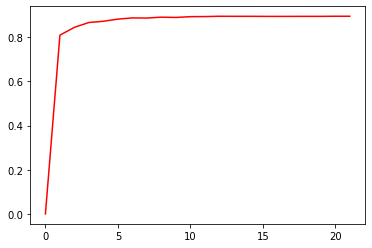

In [12]:
neural_network(train_image,train_labels,20,test_image,test_labels).train()